In [1]:
%reload_ext autoreload
%autoreload 2

In [13]:
import os
import random
import logging
import multiprocessing
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader)

from ctorch.config import ComplexTorchConfig
from ctorch.data_access import DataClass
from ctorch.model import UNetModel
from ctorch.utils import kspace, fft
from ctorch.utils.constants import (
    PROCESSED_DIR,
    TRAIN,
    VAL,
    TEST,
    INPUT,
    TARGET,
    HEIGHT,
    WIDTH,
    SAVED_MODELS_DIR
)

PARENT_PATH = Path(os.getcwd()).parent.absolute()
device = "cuda" if torch.cuda.is_available() else "cpu"

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

# seed everything
seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
config = ComplexTorchConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [4]:
class KSpaceDataset(Dataset):
    def __init__(self, input_path: Path, target_path: Path):
        super().__init__()
        self.input_path = input_path
        self.target_path = target_path
        self.files = sorted(os.listdir(self.input_path))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        X = np.load(os.path.join(self.input_path, file))
        Y = np.load(os.path.join(self.target_path, file))
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        return X, Y

In [5]:
def make_data_loader(
    input_path: Path,
    target_path: Path,
    batch_size: int,
    shuffle: bool = True,
    num_workers: int = 0
    ) -> DataLoader:
    data = KSpaceDataset(input_path=input_path, target_path=target_path)
    data_loader = DataLoader(
        dataset=data,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers=num_workers
    )
    return data_loader

In [6]:
BATCH_SIZE = 16
NUM_WORKERS = max(0, multiprocessing.cpu_count() - 2)

train_input_path = os.path.join(data.data_path, PROCESSED_DIR, TRAIN, INPUT)
train_target_path = os.path.join(data.data_path, PROCESSED_DIR, TRAIN, TARGET)
train_loader = make_data_loader(
    input_path=train_input_path,
    target_path=train_target_path,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_input_path = os.path.join(data.data_path, PROCESSED_DIR, VAL, INPUT)
valid_target_path = os.path.join(data.data_path, PROCESSED_DIR, VAL, TARGET)
valid_loader = make_data_loader(
    input_path=valid_input_path,
    target_path=valid_target_path,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")

Number of training samples: 7056
Number of validation samples: 756


In [7]:
EPOCHS = 200
LEARNING_RATE = 1e-03
FACTOR = 0.1
PATIENCE = 2
VERBOSE = True

model = UNetModel(config)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=FACTOR,
    patience=PATIENCE,
    verbose=VERBOSE
)

saved_models_path = Path(os.path.join(data.current_path, SAVED_MODELS_DIR))
saved_models_path.mkdir(parents=True, exist_ok=True)
print(f"Training with batch size of {BATCH_SIZE} for {EPOCHS} epochs")

Training with batch size of 16 for 200 epochs


In [9]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {pytorch_total_params:,}")

Total trainable parameters: 1,925,988


In [8]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
# train_eval, valid_eval = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    train_batch_eval, valid_batch_eval = list(), list()
    # Training mode
    model.train()
    for i, (x, y) in enumerate(train_loader):
        # Move input to device
        x = x.to(device)
        y = y.to(device)
        # Forward pass
        residual = model(x)
        # Calculate loss
        loss = criterion(torch.view_as_real(residual), torch.view_as_real(y - x))
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        # train_batch_eval.append(eval(residual + x, y))
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append to respective lists
    train_loss.append(np.array(train_batch_loss).mean())
    # train_eval.append(np.array(train_batch_eval).mean(axis=0))
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            # Move input to device
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            residual = model(x)
            # Calculate loss
            loss = criterion(torch.view_as_real(residual), torch.view_as_real(y - x))
            valid_batch_loss.append(loss.item())
            # valid_batch_eval.append(eval(residual+x, y))
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append to respective lists
    valid_loss.append(np.array(valid_batch_loss).mean())
    scheduler.step(valid_loss[-1])
    # valid_eval.append(np.array(valid_batch_eval).mean(axis=0))
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)


 EPOCH:1/200 - Training Loss: 0.0002492343478373902, Validation Loss: 3.94257702277893e-06
 EPOCH:2/200 - Training Loss: 3.963941481349041e-06, Validation Loss: 3.894619924930491e-06
 EPOCH:3/200 - Training Loss: 3.913897730771439e-06, Validation Loss: 3.842131146569727e-06
 EPOCH:4/200 - Training Loss: 3.939398909381384e-06, Validation Loss: 3.780092994768817e-06
 EPOCH:5/200 - Training Loss: 4.02249411865564e-06, Validation Loss: 3.698753180477373e-06
 EPOCH:6/200 - Training Loss: 3.98817136862576e-06, Validation Loss: 3.654470636623349e-06
 EPOCH:7/200 - Training Loss: 4.56542160156579e-06, Validation Loss: 3.518395228496729e-06
 EPOCH:8/200 - Training Loss: 3.541976781916199e-06, Validation Loss: 3.968888250938107e-06
 EPOCH:9/200 - Training Loss: 3.7229784010834133e-06, Validation Loss: 4.264152420792773e-06
 EPOCH:10/200 - Training Loss: 3.689962014389508e-06, Validation Loss: 3.1395784958476725e-06
 EPOCH:11/200 - Training Loss: 3.68829702631063e-06, Validation Loss: 3.056018628

In [12]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 134


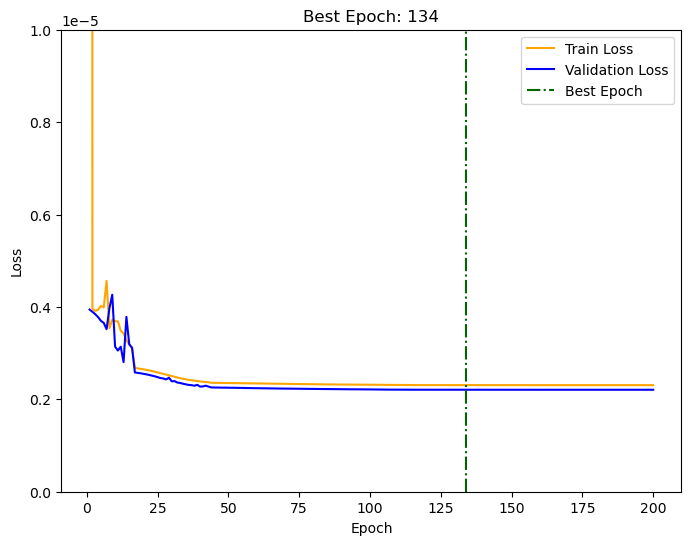

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.ylim(0, 1e-05)
plt.legend(loc="upper right");